## Sections space of a quiver representation

This package provides a simple implementation of the algorithm described in <a href="https://link.springer.com/article/10.1007/s10208-022-09563-x">Principal Components Along Quiver Representations</a> by A. Seigal, H. Harrington and V. Nanda 

In [1]:
from sections_space import compute_sections,nx_graph_to_quiver,Field,eye_mat
import numpy as np
from cfractions import Fraction
import networkx as nx

### Base field

The base field for the computations can be chosen as one of the default fields:

 <ul>
  <li>$\mathbb F_2$: exact computations, implemented in Python</li>
  <li>$\mathbb Q$: exact computations using <a href="https://github.com/python/cpython/tree/main">cfractions</a> </li>
  <li>$\mathbb R$ and $\mathbb C$: using scipy.linalg (mainly SVDs), numerical instabilities for very large quiver representations </li>
</ul> 
Computations in $\mathbb F_2$ and $\mathbb Q$ are exact. 

In [2]:
for description in ['F_2','Q','R','C']:
    field =Field(description)
    
    print(description)
    print("1+1:\t"+repr(field.one +field.one))
    print("------------------------------")

F_2
1+1:	cl(0)
------------------------------
Q
1+1:	Fraction(2, 1)
------------------------------
R
1+1:	2.0
------------------------------
C
1+1:	(2+0j)
------------------------------


(The user can also customise the field by provinding two instances 0 and 1 of an object for which the operations +,-,*,/,(- ),=, str,repr have been overridden.)

### Quiver representations

A quiver $Q$ is a directed graph (with multiple edges and self-loops). The source and target of an edge $e$ are denoted $s(e)$ and $t(e)$. A representation $A$ of $Q$ is the data 
<ul>
    <li>
      for each vertex $v$ of $Q$, of  a vector space $A_v$ 
    </li>
     <li>
      for each edge $e$ of $Q$, of  a linear map $A_e\colon A_{s(e)}\to A_{t(e)}$.
    </li>
</ul>
We further fix bases for each space $A_v$. When $Q$ does not have isolated vertices, the data of $A$ is given by the matrices of the maps $A_e$. In that case, we store $Q$ as a Networkx graph and the matrices of the maps $A_e$ as an edge attribute of the Networkx graph.

In [3]:
field= Field("R")
#cyclic graph
edges = [("v"+str(i),"v"+str((i+1)%4), {"map": np.array([2**(2*(i%2)-1)]).reshape((1,1))}) for i in range(4)]
G= nx.from_edgelist(edges,create_using=nx.DiGraph())
#convert to Quiver
Q=nx_graph_to_quiver(G,field)

Isolated vertices can be input by specifying the space dimension as a node attribute.

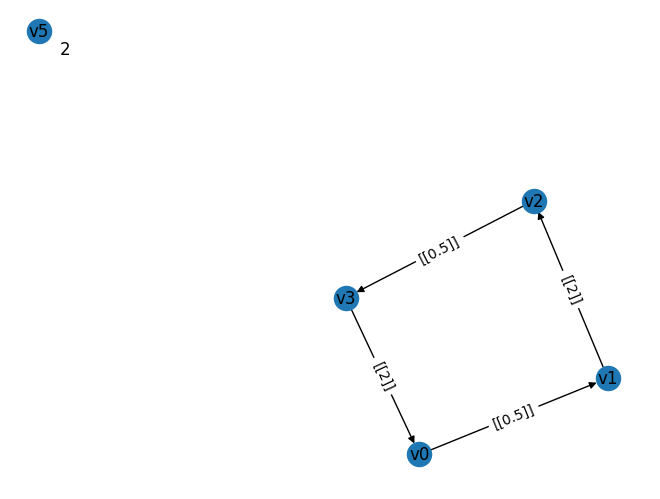

In [4]:
#add an isolated vertex
G.add_node("v5", dim=2)
Q2=nx_graph_to_quiver(G,field)

#draw G
pos=nx.spring_layout(G)
nx.draw(G,pos,arrows=True,with_labels=True)#quiver
e_lab=nx.draw_networkx_edge_labels(G, pos,edge_labels=nx.get_edge_attributes(G,'map'))#maps Ae
pos_above={v: coord*0.925 for v,coord in pos.items()}
v_lab=nx.draw_networkx_labels(G,pos_above,labels=nx.get_node_attributes(G, 'dim'))# dim Av

### Limits and Global sections

The sections space of a quiver representation $A$ is the subspace $\Gamma(Q,V)\subset \prod_v A_v$ of the vectors $(a_v)_v\in \prod_v A_v$ subject to the compatibility relation 
$a_{t(e)}=A_e(a_{s(e)})$ for each edge $e$. 

The function *compute_sections* returns the dimension $d=\dim \Gamma(Q,A)$ and for each vertex $v$ the component along $A_v$ of a base of $\Gamma(Q,A)$.

In [5]:
d,maps=compute_sections(Q2)

print("dim Gamma =",d)
for i in range (Q2.n): 
    print("- map to v"+str(i))
    print(maps[i]) 

dim Gamma = 3
- map to v0
[[0.5 0.  0. ]]
- map to v1
[[0.25 0.   0.  ]]
- map to v2
[[0.5 0.  0. ]]
- map to v3
[[0.25 0.   0.  ]]
- map to v4
[[0. 1. 0.]
 [0. 0. 1.]]


Equivalently, *compute_sections* returns the dimension of the categorical limit $\varprojlim  V$ and the maps $\varprojlim V\to A_v$ for each $v$. For instance, one can compute the equaliser of

$\mathbb Q^3 \qquad \begin{array}{c} \overset{I_3}\longrightarrow\\
\underset{\tiny\left(\begin{array}{ccc} 1&0&0\\0&1&1\\0&0&1\end{array}\right)}\longrightarrow \end{array}\qquad  \mathbb Q^3$

In [6]:
#equaliser
field=Field("Q")
M=eye_mat(3,field)
M[1][2]=field.one
edges = [(0,1, {"map": eye_mat(3,field)}), (0,1,{"map":M}) ]
G= nx.from_edgelist(edges,create_using=nx.MultiDiGraph())
Q=nx_graph_to_quiver(G,field)

#compute limit
d,maps=compute_sections(Q,field)
print("dim Eq=",d)
print("Eq to A_0:")
print(np.vectorize(str)(maps[0]))

dim Eq= 2
Eq to A_0:
[['1' '0']
 ['0' '1']
 ['0' '0']]


### Performances

The following graph shows the performance gain of this algorithm compared to the naive computation $\Gamma(Q,A)= \bigcap_e \ker (\pi_{t(e)}-A_e\circ\pi_{s(e)})$ where $\pi_w\colon \prod_vA_v\to A_w$ is the projection onto $A_w$. Over the field $\mathbb Q$ which perfoms exact computations, the algorithm can compute the sections space for graphs with more than $n=100$ nodes and $m=500$ edges.  

Empiric time performance of the algorithm for random quivers generated using Erdős–Rényi model with $n\in[2,90]$ nodes and $m\approx 2 n^{1.2}$ edges over $\mathbb Q$:

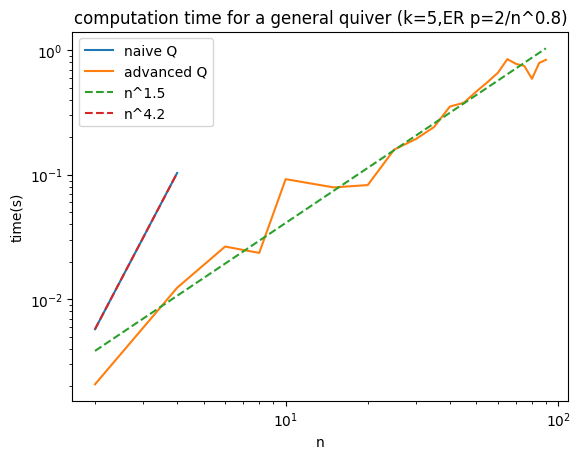

In [7]:
from sections_space.main import generate_random_quiver,sections_naive
from sections_space.aux_fun import test_plot
import matplotlib.pyplot as plt


range_test=list(range(2,10,2))+list(range(10,95,5))
n_test=3
adv_fun=lambda Q: compute_sections(Q)[0] 
Q=generate_random_quiver(range_test,n_test,False,Field('Q'))
#for small n, compute the  sections space using both the naive and the advanced methods, compare and plot
#for large n, compute the sections space using the advanced method and plot
test_plot(Q,sections_naive,adv_fun,range_test,6,n_test,log=True,title="computation time for a general quiver (k=5,ER p=2/n^0.8)")
plt.show()